# Deep Convolution Neuron Network AutoEncoder - Dimensionality Reduction of MNIST FASHION DataSet
Compare the lossy ratio between multiple latent spaces

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy


You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os.path
import PIL
import PIL.Image
import keras_tuner as kt
from sklearn.model_selection import train_test_split


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable float16 bit for improved performance.
        mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-07-22 12:00:56.676095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 12:00:56.698332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 12:00:56.698518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 12:00:56.699522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Load DataSet

In [5]:
def loadDataFashion():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    TrainX = np.concatenate((train_images, test_images))
    # Normalize byte [0,255] -> [0,1]
    TrainX = (TrainX / 255.0)

    return TrainX

    #
def loadMNIST():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    # Normalize byte [0,255] -> [0,1]
    train_X = train_X / 255.0
    test_X = test_X / 255.0

    return np.concatenate((train_X, test_X))


In [6]:
EPOCHS = 96
BATCH_SIZE = 1024

fashionX = loadDataFashion()
MnistX = loadMNIST()

trainX = np.concatenate((fashionX, MnistX)).astype(dtype='float16')


## Presenting Example Data

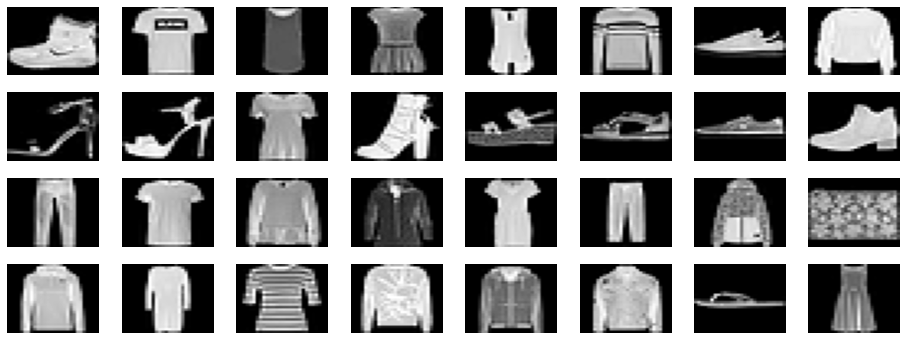

In [7]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, image in enumerate(trainX[0:nrImage]):
    plt.subplot(4, 8, (index + 1))

    plt.imshow(X=((image + 1.0) / 2.0).astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


# Create Dimensionality Reduction Model

In [12]:
def model_constructor(hp, latent_space, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'sigmoid', 'softmax', 'tanh'])
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=4, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=2, max_value=3, step=1)

            self.encoder = tf.keras.Sequential(name="Encoder")
            self.encoder.add(layers.Input(image_size))

            #
            encoder_dense_layers = [layers.Conv2D(filters=256 / (2 ** i), strides=(2, 2), kernel_size=hp_kernel_size, activation=kernel_activation, kernel_initializer=kernel_init, dtype='float32', padding='same')
                                    for i in range(0, number_layers)]

            encoder_last_conv2 = None
            for layer in encoder_dense_layers:
                encoder_last_conv2 = layer
                self.encoder.add(layer)

            # Latent space.
            #self.encoder.add(layers.Dense(latent_space, activation=kernel_activation, kernel_initializer=kernel_init, name="latentspace", dtype='float32'))



            self.decoder = tf.keras.Sequential(name="Decoder")
            
            connect_conv_shape = encoder_last_conv2.output_shape
            self.decoder.add(layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3])))

            decoder_dense_layers = [layers.Conv2DTranspose(filters=256 / (2 ** i), kernel_size=hp_kernel_size, strides=(2, 2), activation=kernel_activation, kernel_initializer=kernel_init, padding='same')
                                    for i in range(0, number_layers)]

            for layer in reversed(decoder_dense_layers):
                self.decoder.add(layer)

            # map the value to [0,1] to prevent color clamping.
            self.decoder.add(layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
            self.decoder.add(layers.Activation(activation='sigmoid', dtype='float32'))
            #self.decoder.add(layers.Dense(np.prod(image_size), activation='sigmoid', kernel_initializer=kernel_init))
            #self.decoder.add(layers.Reshape(image_size))

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

        def getEncoder(self):
            return self.encoder

        def getDecoder(self):
            return self.decoder

        def getModel(self):
            ae_input = layers.Input(shape=image_size, name="AE_input")
            ae_encoder_output = self.getEncoder()(ae_input)
            ae_decoder_output = self.getDecoder()(ae_encoder_output)

            return keras.Model(inputs=ae_input, outputs=ae_decoder_output)

        def compile(self, **kwargs):
            super(Autoencoder, self).compile(**kwargs)

        def summary(self, **kwargs):
            super(Autoencoder, self).summary(**kwargs)
            self.encoder.summary()

    autoencoder = Autoencoder(hp)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    autoencoder.compile(optimizer=hp_optimizer, loss='mse', metrics=['accuracy'])

    return autoencoder


## Hyperparameter
Find the best model out of all the parameters.

In [13]:

image_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

X_train, X_val, y_train, y_val = train_test_split(trainX, trainX, test_size=0.12, random_state=42)

latent_spaces = [1, 2, 4, 8, 16, 32, 64, 128]
ae_models = []

for latent_space in latent_spaces:

    def hyperparamter_model_builder(hp):
        model = model_constructor(hp, latent_space, image_shape)
        return model

    tuner = kt.Hyperband(hyperparamter_model_builder,
                         objective='val_accuracy',
                         max_epochs=16,
                         factor=3,
                         directory='cache',
                         project_name=str.format('MNIST DCNN AutoEncoder Reconstruct L{0} - {1}', latent_space, "Compression"))

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4)
    tuner.search(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),
                 callbacks=[stop_early], verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_models = tuner.get_best_models(4)

    autoencoder_model = tuner.hypermodel.build(best_hps)

    ae_models.append(autoencoder_model)


INFO:tensorflow:Reloading Oracle from existing project cache/MNIST DCNN AutoEncoder Reconstruct L1 - Compression/oracle.json
INFO:tensorflow:Reloading Tuner from cache/MNIST DCNN AutoEncoder Reconstruct L1 - Compression/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
he_uniform        |glorot_normal     |kernel_initializer
tanh              |softmax           |kernel_activation
3                 |3                 |kernel_size
1                 |1                 |number_layers
rmsprop           |sgd               |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
113/121 [===========================>..] - ETA: 0s - loss: 0.0285 - accuracy: 0.6592

KeyboardInterrupt: 

## Train Finalize Model

In [ ]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 2 * 2))
    for i in range(nrElements):
        trainImage = image

        ax = plt.subplot(2, maxNumImages, i + 1)
        plt.imshow((batchImage[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(2, maxNumImages, maxNumImages + i + 1)
        plt.imshow((output[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData[0:20]
        self.latent_space = latent_space
        self.dir_path = dir_path
        os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("{0}/MNISTDimRedL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("{0}MNISTDimRedBigL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))


In [ ]:
model_results = []

for latent_space, ae_model in zip(latent_spaces, ae_models):

    # Construct the checkpoint path for specific latent space size.
    checkpoint_path = str.format("checkpoints/mnist_dcnn_autoencoder_l{}_compression/cp.ckpt", latent_space)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=autoencoder_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        autoencoder_model.load_weights(checkpoint_path)

    model_history = ae_model.fit(trainX, trainX,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 verbose=1, callbacks=[cp_callback, save_images(str.format("dcnn_mnist_latent_{0}", latent_space), latent_space, trainX)])
    model_results.append(model_history)
    autoencoder_model.save_weights(checkpoint_path)
    del ae_model


FileExistsError: [Errno 17] File exists: 'mnist_latent_1'

In [ ]:
# Plot Result
predictData = trainX[0:9]
for model in ae_models:
    result = model.predict(predictData, verbose=0)


1/1 [==============================] - 0s 9ms/step


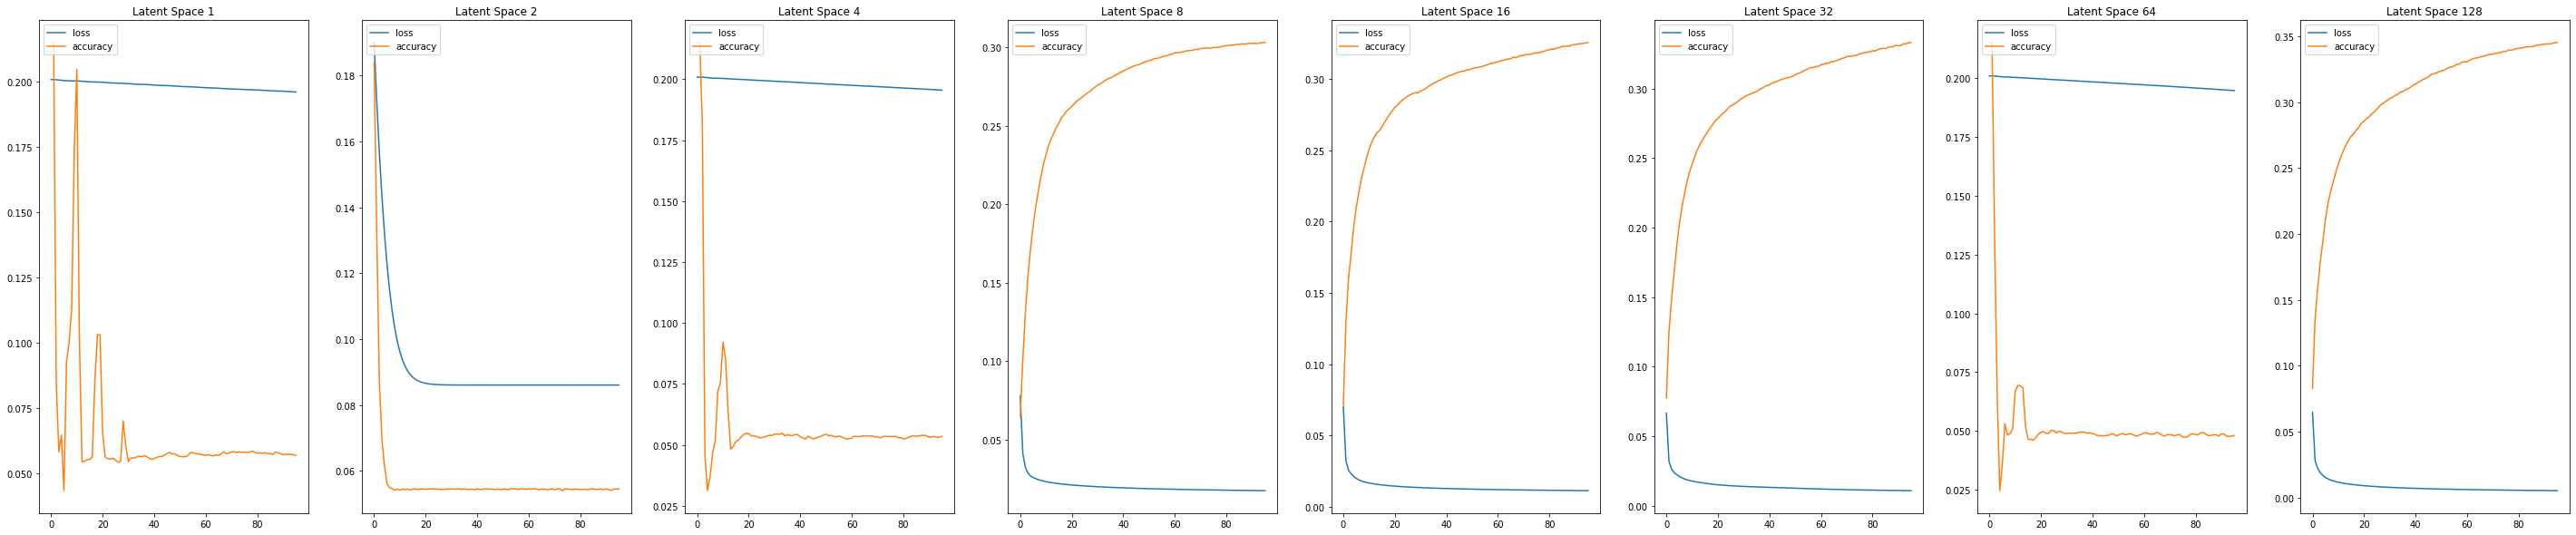

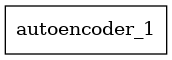

<Figure size 432x288 with 0 Axes>

In [ ]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10))
    for i, result in enumerate(results):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', 2 ** i))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "CNN {0} Performance History", "Fashion"))

tf.keras.utils.plot_model(
    autoencoder_model, to_file=str.format('cnn_{0}_model.png', "Fashion"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)


## Model Neuron Networks

In [ ]:
for model in ae_models:
    ae_model = model.getModel()
    ae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 244225    
                                                                 
 sequential_3 (Sequential)   (None, 28, 28)            245008    
                                                                 
Total params: 489,233
Trainable params: 489,233
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 sequential_2 (Sequential)   (None, 2)

##